In [2]:
# Import libraries
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import skgstat as skg
import gstools as gs

import matplotlib.pyplot as plt

In [3]:
# Specify filepaths and filenames.
filepath = 'Data/'
filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Make column with year from current year max date
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

print(data.shape)

(4044, 302)


In [3]:
# Get stats
# Stats for quality of approximate locations and altitudes:
mean_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].mean()
min_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].min()
max_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].max()
sd_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].std()

mean_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].mean()
min_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].min()
max_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].max()
sd_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].std()

mean_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].mean()
min_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].min()
max_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].max()
sd_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].std()

# Number of instances of winter balance: 3680
no_winter = data['balance_winter'].notna().sum()

# Number of instances of summer balance: 3805
no_summer = data['balance_summer'].notna().sum()

# Number of instances of annual balance: 3839
no_annual = data['balance_netto'].notna().sum()

# Number of points with exact coordinates: 3717 of 4046
no_exact_locs = (data['approx_loc'].values == 'N').sum()

# Number of points with approximate coordinates: 329 of 4046
no_approx_locs = (data['approx_loc'].values == 'Y').sum()
    
# Number of points with exact altitude: 4009
no_exact_alt = (data['approx_altitude'].values == 'N').sum()

# Number of points with exact altitude: 37
no_approx_alt = (data['approx_altitude'].values == 'Y').sum()

# Number of points w/o exact coordinates or altitude: 32
no_approx_both = ((data['approx_altitude'].values == 'Y') & (data['approx_loc'].values == 'Y')).sum()
   
# Number of unique glacier IDs: 32
no_unique_id = data['BREID'].nunique()    

# List of unique glacier IDs:
list_unique_id = list(data['BREID'].unique())

# Unique glacier IDs with number of entries per ID.
# Index is glacier ID and column is number of entries per glacier ID.
len_rec_per_id = data['BREID'].value_counts().to_frame()    

In [4]:
# Summary
print('Total number of points: ' + str(data.shape[0]))
print('Number of unique ids: ' + str(no_unique_id))
print('Number of annual mass balance: ' + str(no_annual))
print('Number of winter mass balance: ' + str(no_winter))
print('Number of summer mass balance: ' + str(no_summer))

Total number of points: 4044
Number of unique ids: 32
Number of annual mass balance: 3839
Number of winter mass balance: 3680
Number of summer mass balance: 3803


<Figure size 640x480 with 0 Axes>

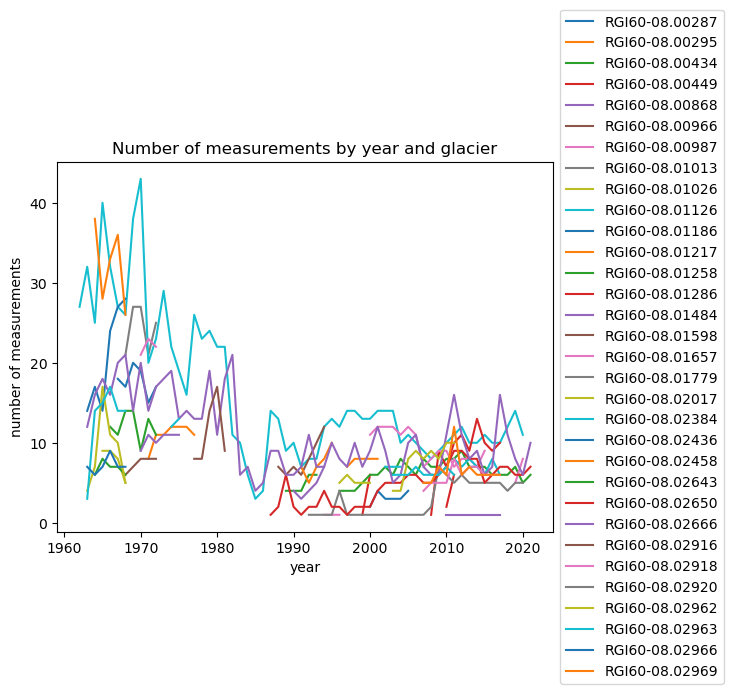

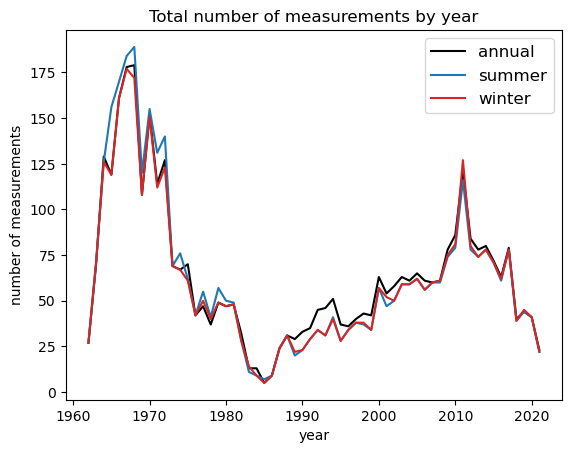

In [5]:
# Plot number of measurements by year, RGIID and type of measurement

# Plot number of measurements per glacier
plt.figure()
data.groupby(['year', "RGIID"]).size().unstack().plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Number of measurements by year and glacier')
plt.ylabel('number of measurements')
plt.show()

data_netto = data[~data['balance_netto'].isnull()]
data_summer = data[~data['balance_summer'].isnull()]
data_winter = data[~data['balance_winter'].isnull()]

# Plot number of measurements per type of measurement
plt.figure()
data_netto.groupby(['year']).size().plot(color='k', legend='annual')
data_summer.groupby(['year']).size().plot(color='C0', legend='summer')
data_winter.groupby(['year']).size().plot(color='C3', legend='winter')
plt.title('Total number of measurements by year')
plt.ylabel('number of measurements')
plt.legend(['annual', 'summer', 'winter'], prop={'size': 12})
plt.show()

# TO-DO: Plot CUMULATIVE number of measurements per type of measurement

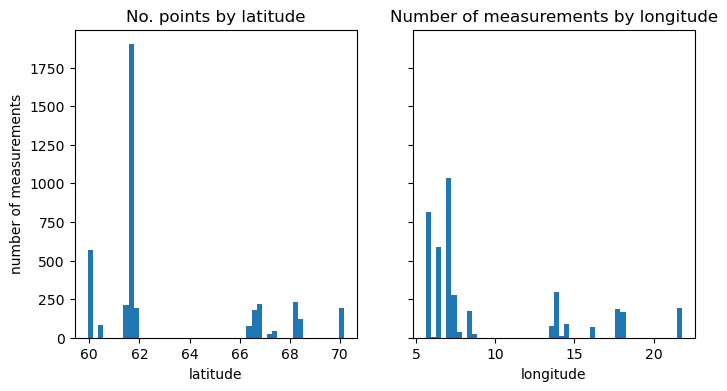

In [7]:
# Plot number of measurements by geographical location

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
data['lat'].plot.hist(bins=50, ax=ax1)
ax1.set_title('No. points by latitude')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('latitude')
data['lon'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Number of measurements by longitude')
ax2.set_ylabel('number of measurements')
ax2.set_xlabel('longitude')

# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

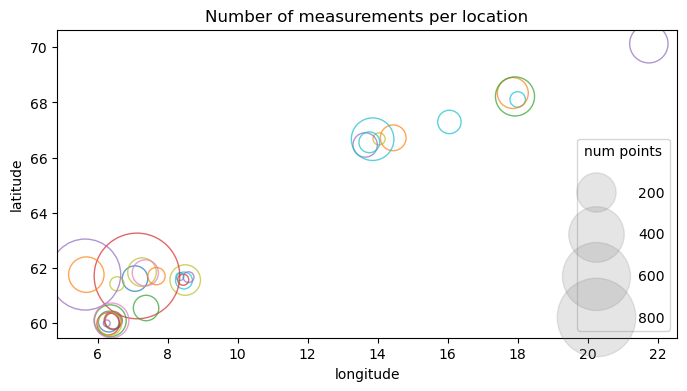

In [6]:
# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

plt.figure(figsize=(8,4))
#labels = list(data['RGIID'].unique())
sc=plt.scatter(x=data.groupby(["RGIID"])['lon'].mean().values, 
               y=data.groupby(["RGIID"])['lat'].mean().values, 
               s=data.groupby(["RGIID"]).size().values*4,
               facecolors='None', edgecolors=c, lw=1, alpha=0.7)#alpha=0.5)#, markerfacecolor="None");#* 200);
#data_netto['lat'].plot.hist(bins=50)
handles, labels = sc.legend_elements(prop="sizes", alpha=0.2, num=5, color='grey')#, fill=None)     
labels = ["200", "400", "600", "800"]     
legend = plt.legend(handles, labels, loc="lower right", title="num points",labelspacing=2, handletextpad=2)
#plt.legend(*sc.legend_elements("sizes", num=6))
plt.title('Number of measurements per location')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

Text(0.5, 0, 'slope (radians? 0.5rad = 28.7deg)')

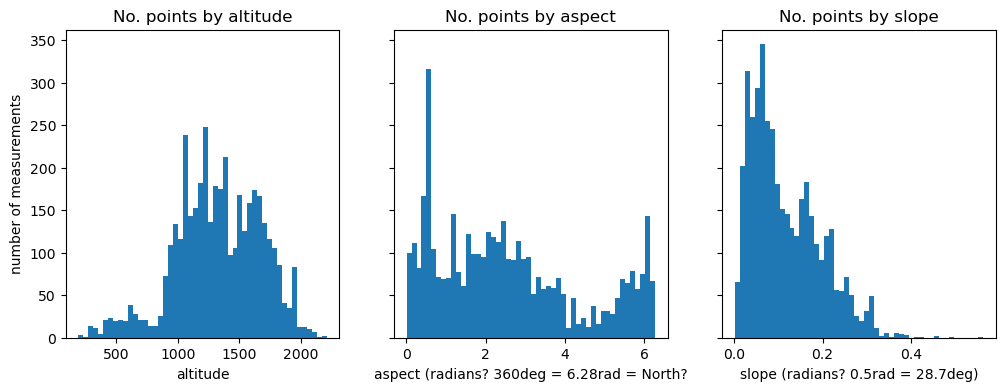

In [8]:
# Number of measurements by topography

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)
data['altitude'].plot.hist(bins=50, ax=ax1)
ax1.set_title('No. points by altitude')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('altitude')

data['aspect'].plot.hist(bins=50, ax=ax2)
ax2.set_title('No. points by aspect')
ax2.set_xlabel('aspect (radians? 360deg = 6.28rad = North?')

data['slope'].plot.hist(bins=50, ax=ax3)
ax3.set_title('No. points by slope')
ax3.set_xlabel('slope (radians? 0.5rad = 28.7deg)')

Text(0.5, 0, 'winter mass balance')

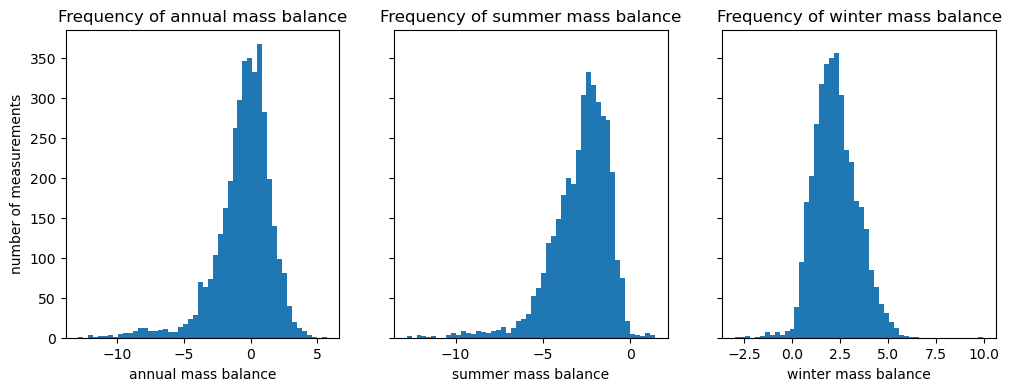

In [9]:
# Number of measurements by mass balance

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)
data['balance_netto'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Frequency of annual mass balance')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('annual mass balance')

data['balance_summer'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Frequency of summer mass balance')
ax2.set_xlabel('summer mass balance')

data['balance_winter'].plot.hist(bins=50, ax=ax3)
ax3.set_title('Frequency of winter mass balance')
ax3.set_xlabel('winter mass balance')

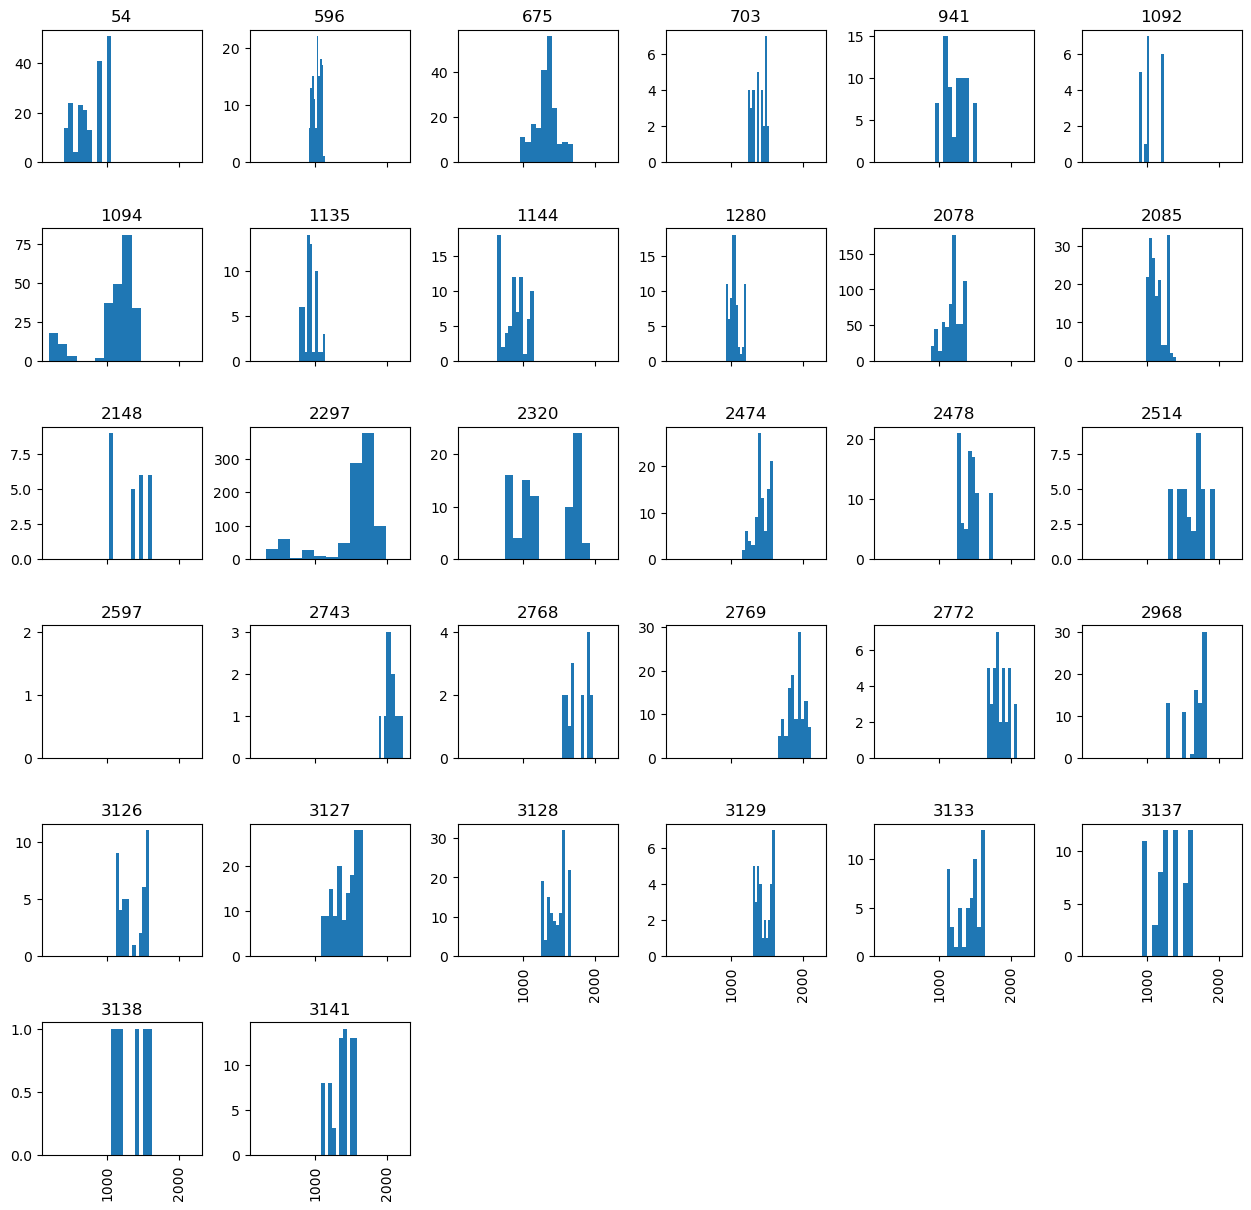

In [10]:
# Plot altitude distribution per glacier
data['altitude'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

In [11]:
data.loc[data['BREID']==2597, ['balance_netto','altitude']]


,balance_netto,altitude
3198,-3.70,1886.0
3199,-1.88,1885.0
3200,0.07,1884.0
3201,-1.55,1882.0
3202,-2.30,1882.0
3203,0.57,1880.0
3204,-1.20,1884.0
3205,0.25,1883.0


### Mass balance per glacier

Only two glaciers have mass balance values in the order of -10 m w.e: 1094 (Engabreen, high latitude, low elevation) and 2297 (Nigardsbreen, low latitude, low elevation)

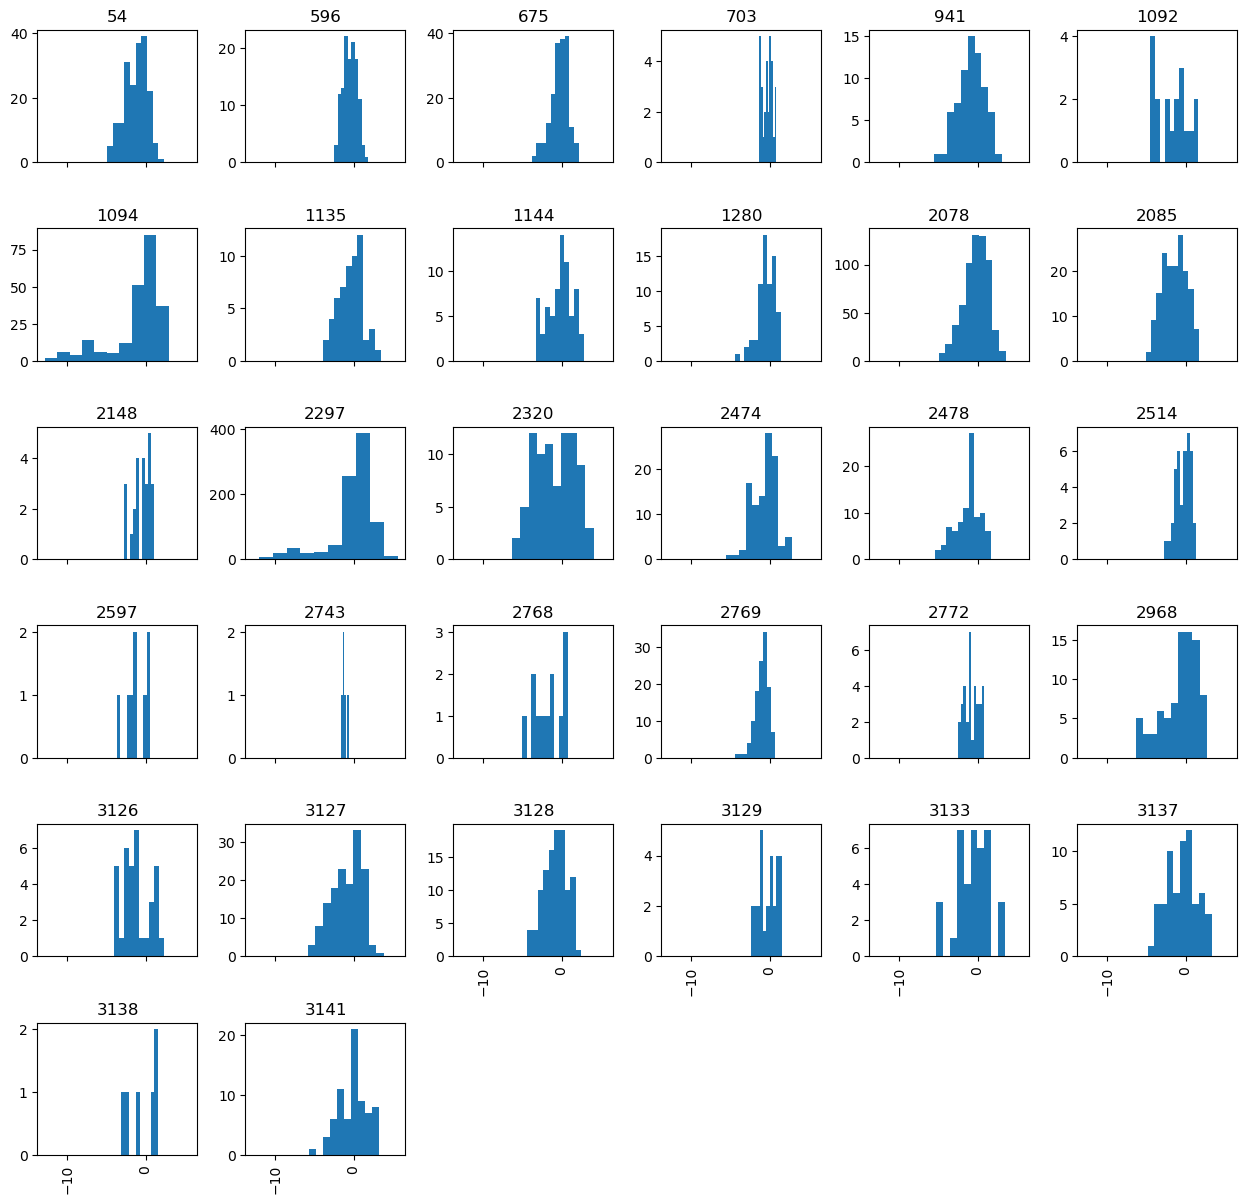

In [12]:
# Plot mass balance values per glacier
data['balance_netto'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

In [13]:
print('Number of measurements of mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.count())
print('Glaciers with mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.unique())
print('Number of measurements of mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.count())
print('Glaciers with mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.unique())

Number of measurements of mass balance values lower than -5 m w.e.:  132
Glaciers with mass balance values lower than -5 m w.e.:  [ 941 1094 2085 2297 2320 2474 2478 2768 2968 3127 3133 3141]
Number of measurements of mass balance values lower than -10 m w.e.:  13
Glaciers with mass balance values lower than -10 m w.e.:  [1094 2297]


## Mass balance by altitude

In [85]:
#Dictionary of region per glacier ID
mapping = {54 : 'FIN', 596 : 'NAR', 675 : 'NAR', 941 : 'BLA', 1092 : 'SVA',
           1094 : 'SVA', 1135 : 'SVA', 1280 : 'SVA', 1144 : 'SVA', 2078 : 'ALF',
           2085 : 'ALF', 2148 : 'JOB', 2297 : 'JOB', 2320 : 'JOB', 2474 : 'JOB',
           2478 : 'JOB', 2514 : 'JOB', 2968 : 'HAR', 2597 : 'JOT', 2768 : 'JOT',
           2769 : 'JOT', 2772 : 'JOT', 2743 : 'JOT', 2769 : 'JOT', 3126 : 'FOL', 
           3127 : 'FOL', 3128 : 'FOL', 3129 : 'FOL', 3133 : 'FOL', 3137 : 'FOL', 
           3138 : 'FOL', 3141 : 'FOL'}

# Map region to glacier ID
data['region'] = data.BREID.map(mapping)


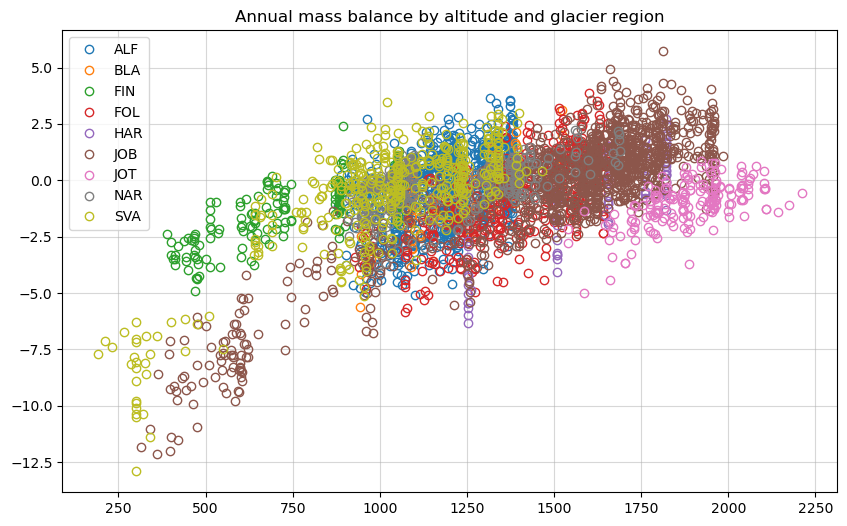

In [86]:
# Group glaciers by region
groups = data.groupby('region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None')
ax.legend()
ax.set_title('Annual mass balance by altitude and glacier region')
plt.grid(alpha=0.5)
plt.show()

In [87]:
#Dictionary of region per glacier ID
mapping_reg = {'FIN' : 'N', 'BLA' : 'N', 'NAR' : 'N', 'SVA' : 'N', 
           'ALF' : 'W-mar', 'FOL' : 'W', 'HAR' : 'W', 'JOB' : 'W', 'JOT' : 'E'}
data['geo_region'] = data.region.map(mapping_reg)


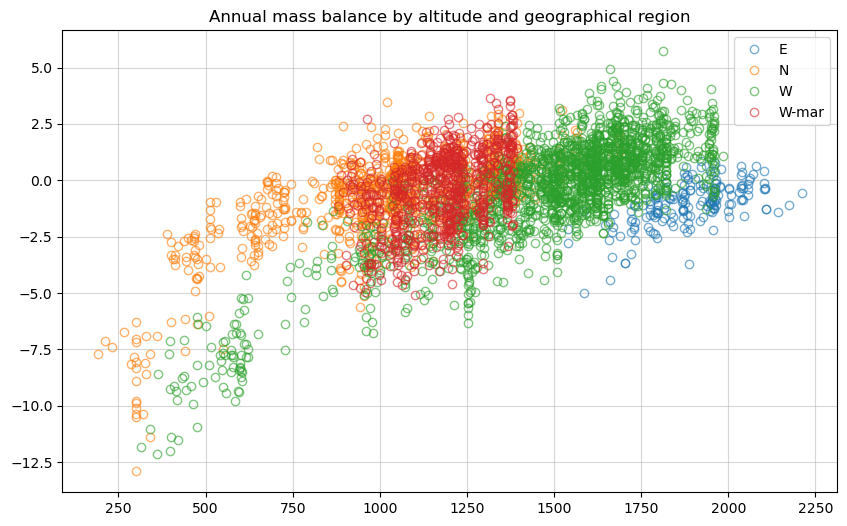

In [88]:
# Group glaciers by broader geographical region
groups = data.groupby('geo_region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None', alpha=0.6)
ax.legend()
ax.set_title('Annual mass balance by altitude and geographical region')
plt.grid(alpha=0.5)
plt.show()

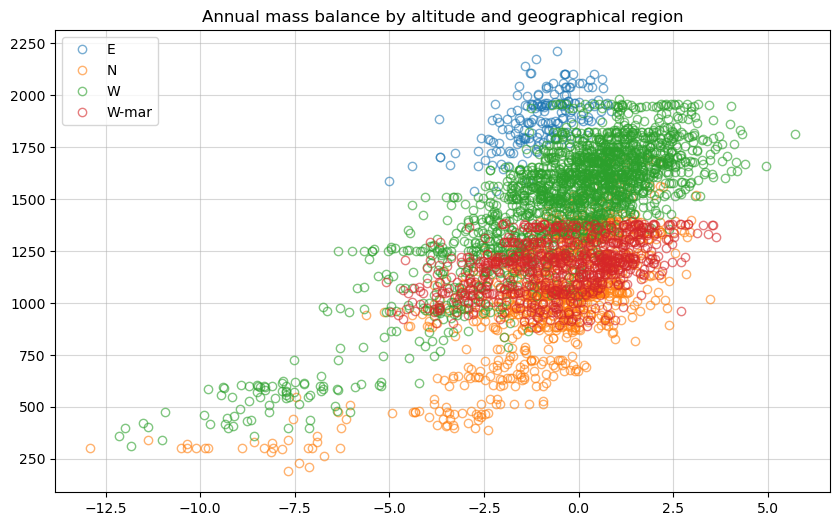

In [89]:
# Group glaciers by broader geographical region
groups = data.groupby('geo_region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.balance_netto, group.altitude, marker='o', linestyle='', ms=6, label=name, mfc='None', alpha=0.6)
ax.legend()
ax.set_title('Annual mass balance by altitude and geographical region')
plt.grid(alpha=0.5)
plt.show()

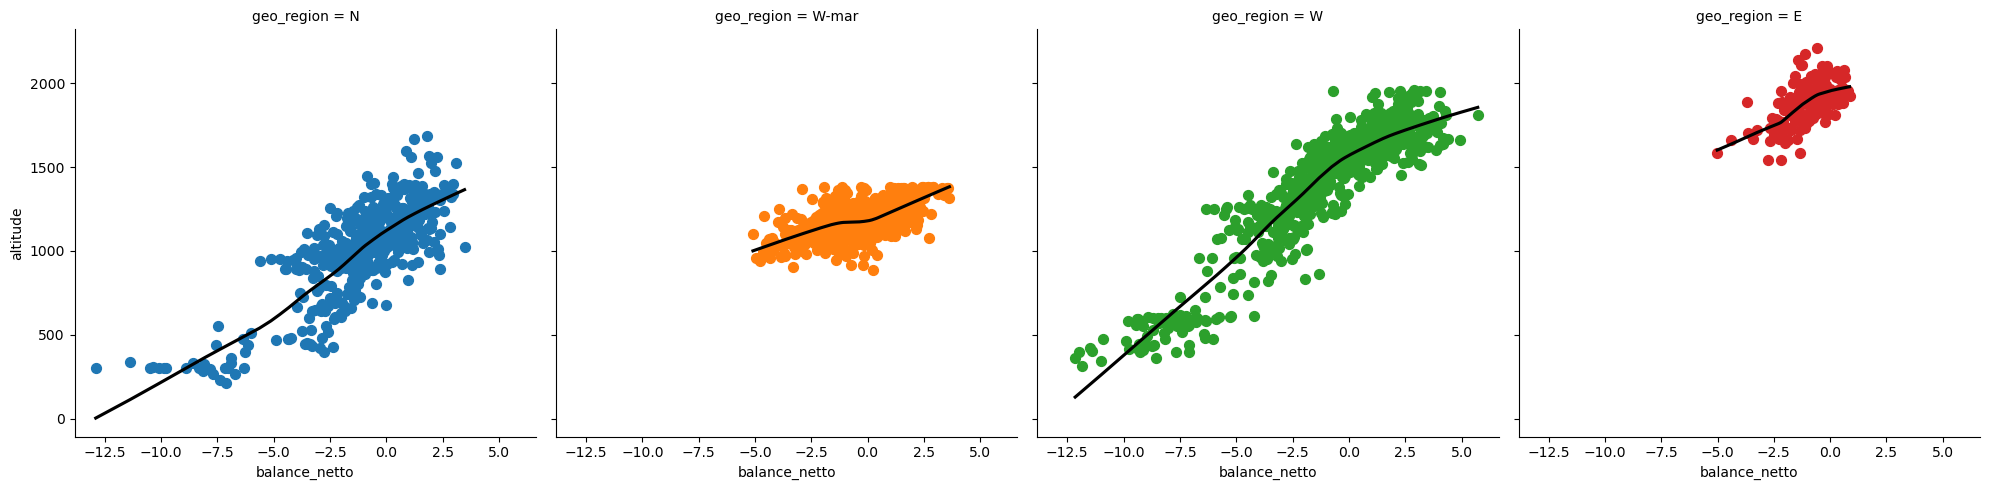

In [98]:
# Lowess
sns.lmplot(data=data, x="balance_netto", y="altitude", hue="geo_region", col='geo_region', lowess=True, ci=None, line_kws={'color': 'k'},
          x_estimator=np.median)


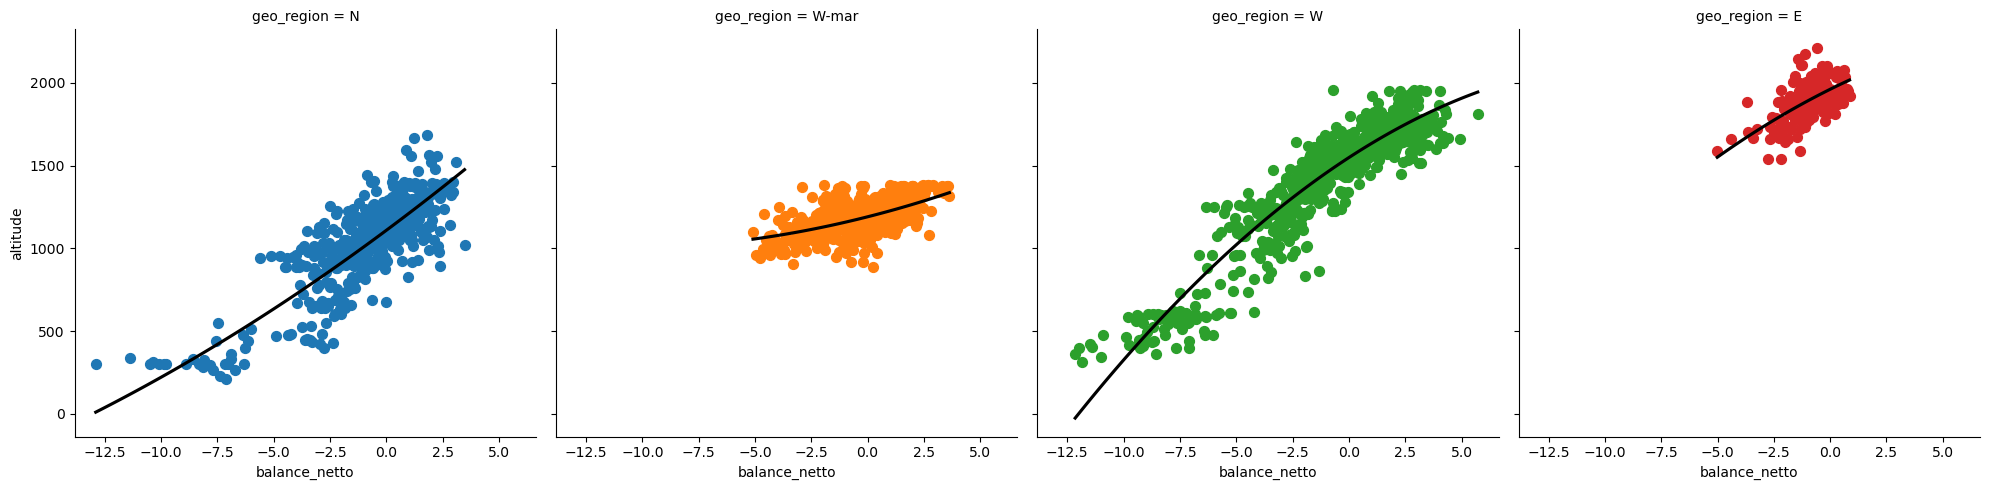

In [99]:
# 2nd order polynomial:
sns.lmplot(data=data, x="balance_netto", y="altitude", hue="geo_region", col='geo_region', order=2, ci=None, line_kws={'color': 'k'},
          x_estimator=np.mean)


## Mass balance distribution plots

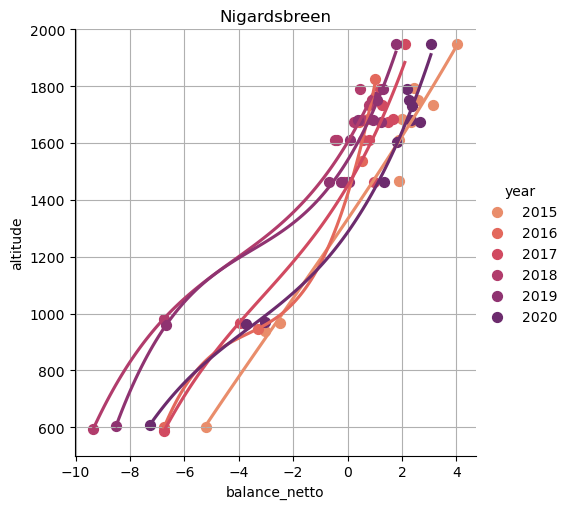

In [108]:
# NIGARDSBREEN MB GRADIENT

data_nig = data[data['BREID']==2297]
#list_yrs = [1962, 1963, 1964, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
#            2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019, 2020]
data_nig_2000 = data_nig[(data_nig['year']>2014) & (data_nig['year']<2022)]
#data_nig_2000 = data_nig[data_nig['year'].isin(list_yrs)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_nig_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Nigardsbreen')
plt.show()

# Nigardsbreen altitude range 1952 m a.s.l. down to 330 m a.s.l. (from NVE "Glaciological investigations in Norway 2018). 


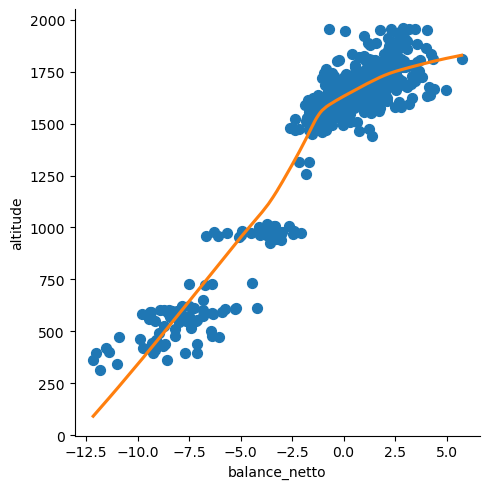

In [73]:
s=sns.lmplot(x='balance_netto', y='altitude', data=data_nig, ci=None, palette='flare', truncate=True,
            x_estimator=np.mean, lowess=True, line_kws={"color": "C1"})


#sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean);


In [32]:
data_nig[(data_nig['year']>2014) & (data_nig['year']<2022)].altitude.max()


1950.0

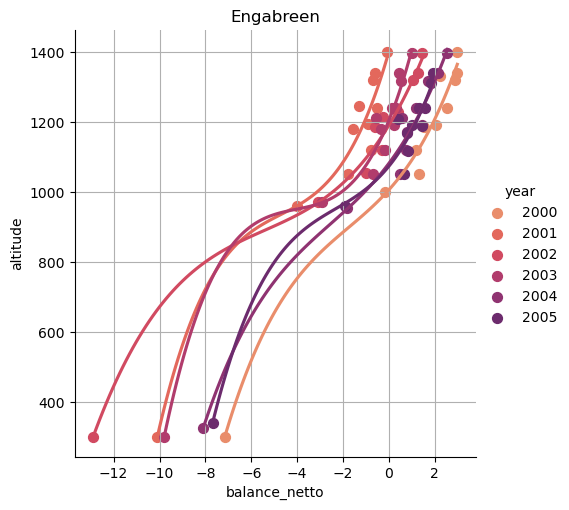

In [131]:
# ENGABREEN MB-GRADIENT

data_eng= data[data['BREID']==1094]
data_eng_2000 = data_eng[(data_eng['year']>1999) & (data_eng['year']<2006)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_eng_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Engabreen')
plt.show()

# Engabreen altitude range 111-1544 masl. (from NVE "Glaciological investigations in Norway 2018). 

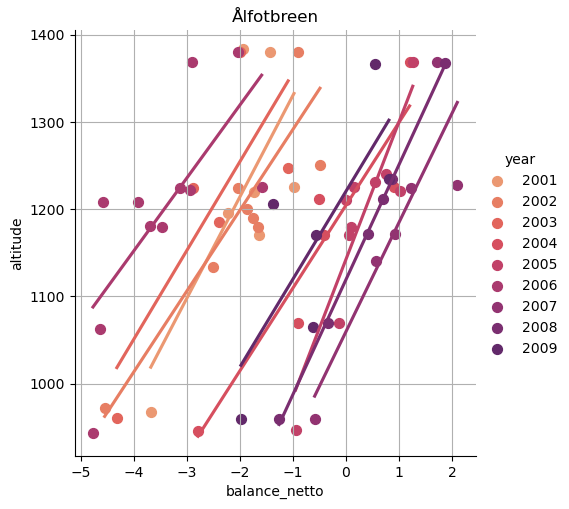

In [135]:
# ÅLFOTBREEN MB GRADIENT

data_alf= data[data['BREID']==2078]
data_alf_2000 = data_alf[(data_alf['year']>2000) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=1, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Ålfotbreen')
plt.show()

# Ålfotbreen altitude range 890-1368 masl. (from NVE "Glaciological investigations in Norway 2018). 

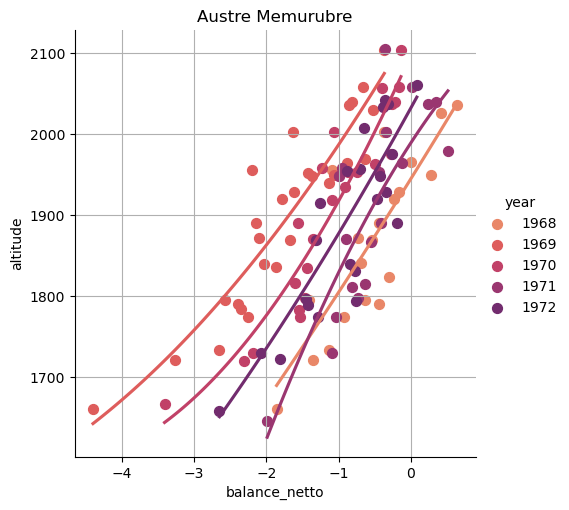

In [126]:
# AUSTRE MEMURUBRE MB GRADIENT

data_alf= data[data['BREID']==2769]
data_alf_2000 = data_alf[(data_alf['year']>1960) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=2, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Austre Memurubre')
plt.show()

# Austre Memurubre altitude range XXXX-XXXX masl.  

In [9]:
#for i, group in data_nig.groupby('year'):
#    sns.lmplot(x="balance_netto", y="altitude", data=group, fit_reg=False)
#plt.show()

In [132]:
# Group point measurements by year
#groups = data_nig.groupby('year')

# Plot mass balance as a function of altitude per year
#fig, ax = plt.subplots(figsize=(10,6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#for year, group in groups:
#    ax.plot(group.balance_netto, group.altitude, marker='o', linestyle='', ms=6, label=year, mfc='None', alpha=0.6)
#ax.legend()
#ax.set_title('Annual mass balance by altitude and geographical region')
#plt.grid(alpha=0.5)
#plt.show()

## Auto-correlation

Autocorrelation is just the correlation of the data with itself. Instead of measuring the correlation between two random variables, 
we are measuring the correlation between a random variable against itself.

In [4]:
data_nig = data[data['BREID']==2297]

In [3]:
data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())
data_nig = data_nig.sort_values(['count','location_id'], ascending=[False, True]).drop('count', axis=1)

# List of 10 stakes locations with longest series
#10 stake locations with length (years): 58, 55, 49, 45, 42, 41, 38, 37, 36, 35
stake_list = data_nig.location_id.unique()[0:10]


C:\Users\kasj\AppData\Local\Temp\ipykernel_19376\1654643696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())


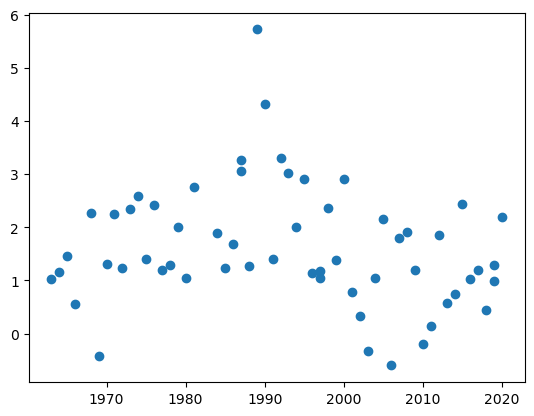

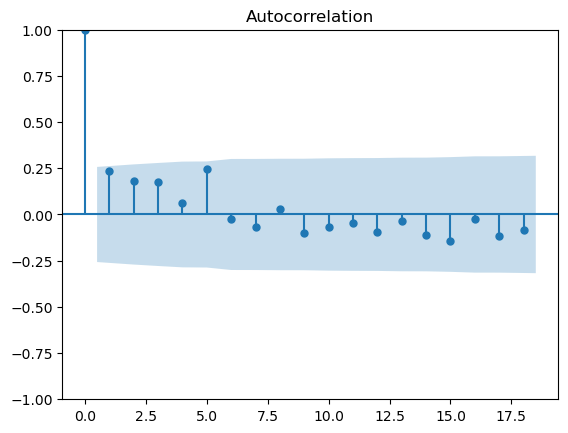

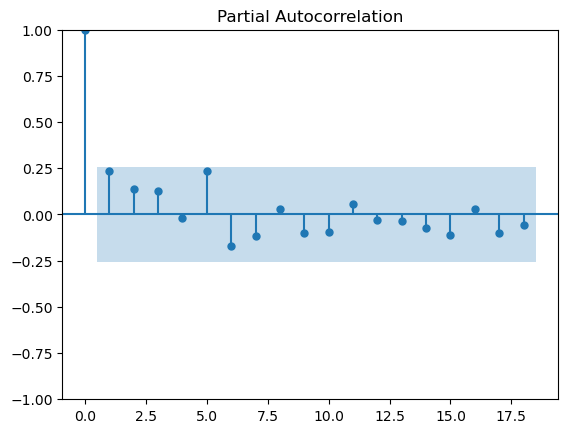

In [23]:
data_stake = data_nig[data_nig.location_id == stake_list[0]]
#data_stake = data_nig[data_nig.location_id == 'N56']
#data_nig = data_nig.sort_values(by=['year'])

plt.plot(data_stake['year'], data_stake['balance_netto'], marker = 'o', linestyle='')
plt.show()

# Use the Autocorrelation function from the statsmodel library passing our DataFrame object in as the data
plot_acf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

plot_pacf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

In [24]:
# Some stake locations contain more than one stake measurements:
data_stake.loc[(data_stake['year']==1995), ['stake_no','altitude','utm_east','utm_north','balance_netto','dt_curr_year_min_date','dt_curr_year_max_date']]

,stake_no,altitude,utm_east,utm_north,balance_netto,dt_curr_year_min_date,dt_curr_year_max_date
2363,N56,1801.0,398068.0,6841212.0,2.91,30.09.1995 00:00,23.04.1995 00:00


## Variograms

The variogram relates the separating distance between two observation points to a measure of observation similarity at that given distance (https://scikit-gstat.readthedocs.io/en/latest/userguide/variogram.html).

If variance is increasing with distance, points that are distant to each other are less related.

In [136]:
data_nig = data[data['BREID']==2297]


In [137]:
plt.style.use('ggplot')
x = data_nig['lon'].values
y = data_nig['lat'].values
mb = data_nig['balance_netto'].values

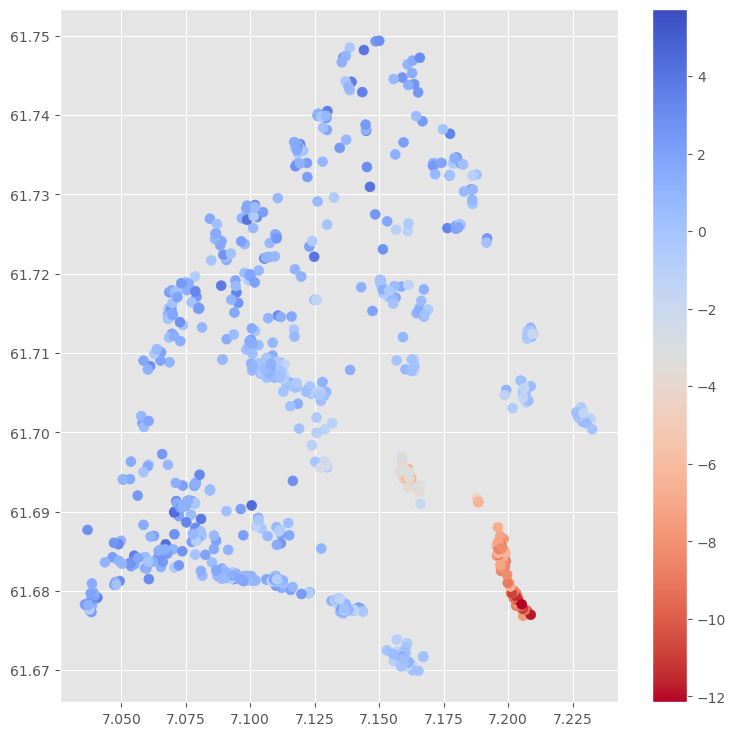

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(x, y, s=50, c=mb.flatten(), cmap='coolwarm_r')
plt.colorbar(art)

In [142]:
coords = np.stack((x,y), axis=1)

In [143]:
coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

In [144]:
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

In [148]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb)

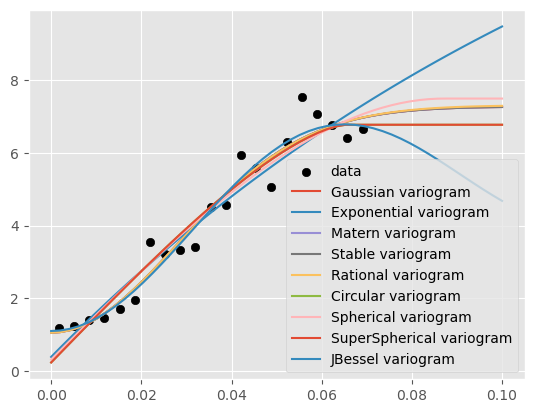

In [152]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=0.1, ax=ax)
    scores[model] = r2

In [153]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.         JBessel: 0.95588
     2.          Matern: 0.95195
     3.          Stable: 0.95195
     4.        Gaussian: 0.95195
     5.        Rational: 0.95181
     6.  SuperSpherical: 0.94118
     7.        Circular: 0.94118
     8.       Spherical: 0.93757
     9.     Exponential: 0.93201


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Stable(dim=2, var=10.1, len_scale=0.057, nugget=0.0, alpha=1.13)


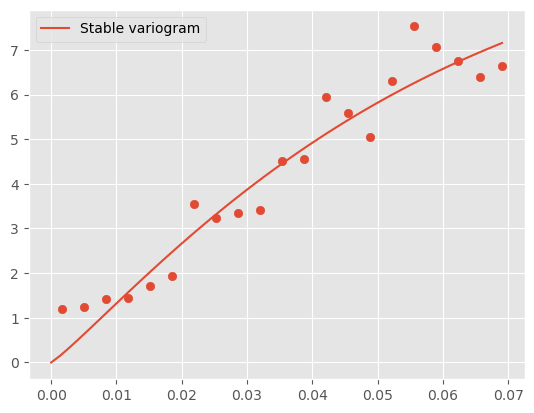

In [141]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb)
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

Spherical(latlon=True, var=7.88, len_scale=11.2, nugget=0.423, geo_scale=6.37e+03)


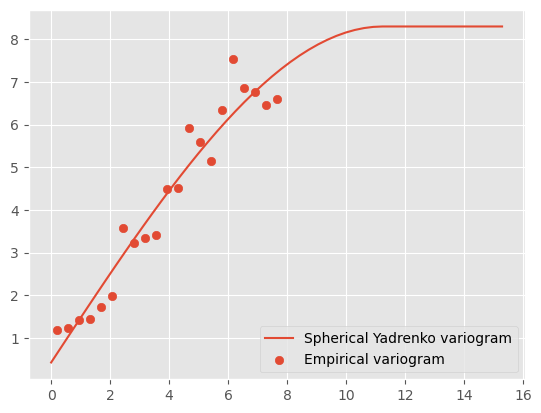

In [17]:
emp_v = gs.vario_estimate(coords.T, mb_clean.T, latlon=True, geo_scale=gs.KM_SCALE)
sph = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
sph.fit_variogram(*emp_v, sill=np.var(mb_clean.T))
ax = sph.plot("vario_yadrenko", x_max=2 * np.max(emp_v[0]))
ax.scatter(*emp_v, label="Empirical variogram")
ax.legend()
print(sph)

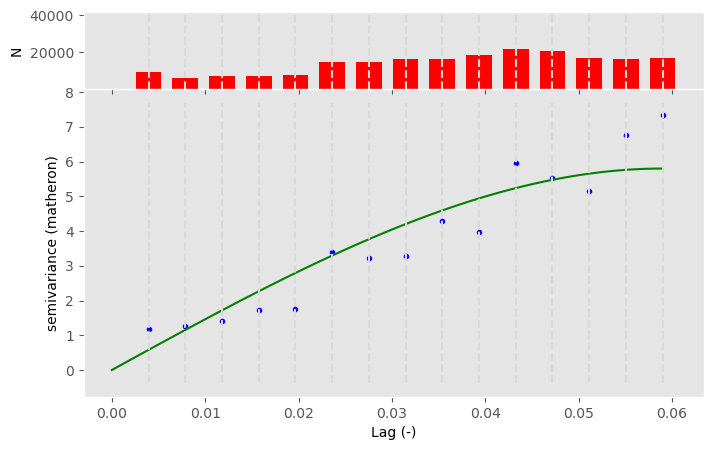

In [85]:
 V = skg.Variogram(coords, mb_clean.flatten(), maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)

In [71]:
print(V.describe())

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': 0.0034805393796178675, 'normalized_sill': 42.51446154409375, 'normalized_nugget': 0, 'effective_range': 0.058996096308297094, 'sill': 5.800714895222548, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 0.05899609630829712, 'n_lags': 15, 'verbose': False}, 'kwargs': {}}


In [16]:
list = [2297, 2478]
data_nig_aus = data[data['BREID'].isin(list)]
x = data_nig_aus['lon'].values
y = data_nig_aus['lat'].values
mb = data_nig_aus['balance_netto'].values
coords = np.stack((x,y), axis=1)
coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

## Correlation plots

<Axes: >

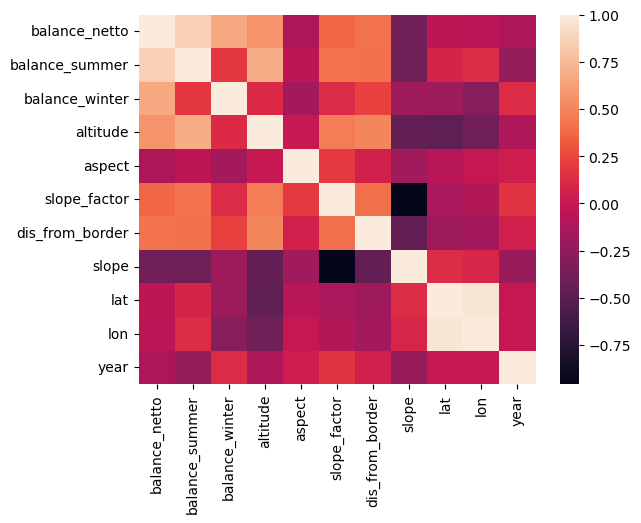

In [36]:
#Plot correlations topo
columns=['balance_netto','balance_summer','balance_winter','altitude','aspect',
         'slope_factor', 'dis_from_border','slope','lat','lon','year']
corr = data[columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Negative correlation between annual/summer balance and slope (higher slope = more positive mb?).
Negative correlation between altitude and slope (higher altitude = lower slope)

Lower elevations have steeper slopes - Nigardsbreen?

Slope correlates with slope factor, remove slope factor from features.

In [49]:
list_cols = list(data.columns)#.to_list#[[-168,:]]
columns = ['balance_netto','balance_summer','balance_winter']
columns.extend(list_cols[-169:])
corr = data[columns].corr()


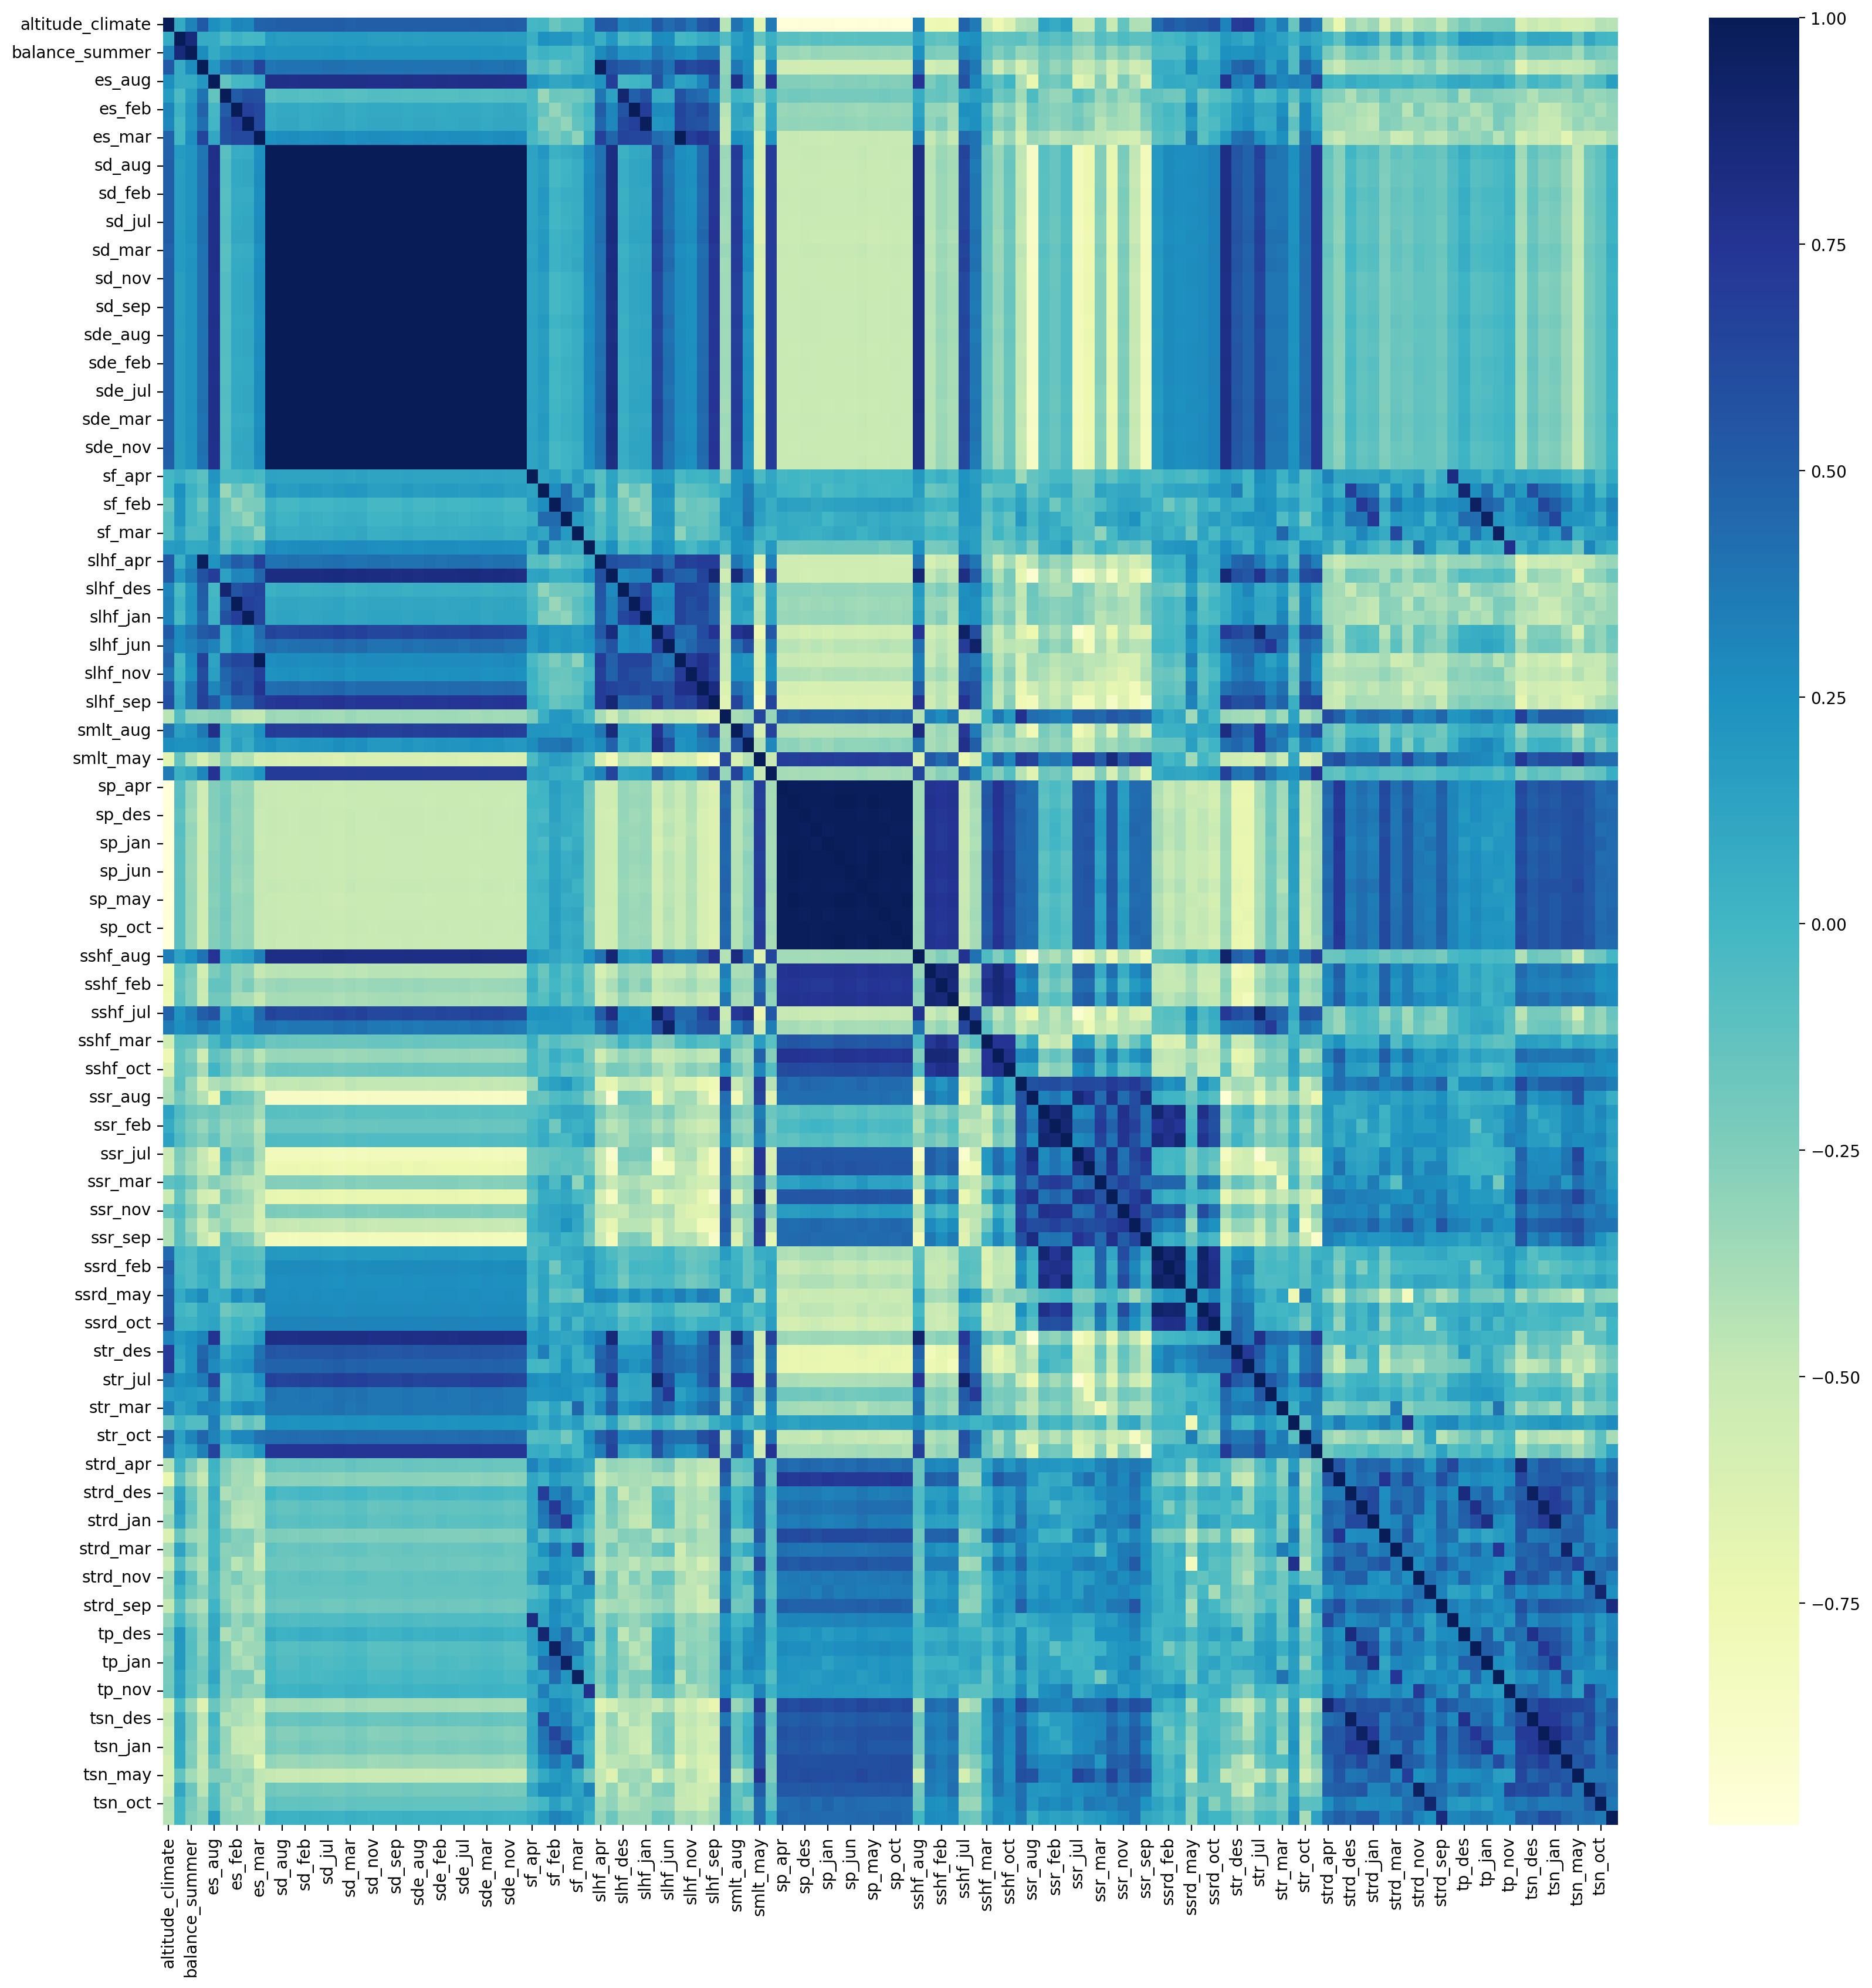

In [54]:
from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations

def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

#labels = [chr(x) for x in range(65,91)]
#corrDf = DataFrame(randn(26,26), index=labels, columns=labels).corr()

#heatmap(corrDf,cmap="YlGnBu")
fig, ax = plt.subplots(1,1,figsize=(20,20), dpi=200)
heatmap(absHighPass(corr,0.75),cmap="YlGnBu", ax=ax)
show()